In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bps = pd.read_csv('./simdata_all_bps_comparison.csv', header=None)

In [3]:
bps.columns = ['idx','log_sp','stdev']

In [4]:
bps.head()

,idx,log_sp,stdev
0,530,2.74052,0.325189
1,543,2.24019,0.294687
2,737,2.13791,0.272189
3,275,1.86415,0.246528
4,762,1.80015,0.234840


In [5]:
bps.sort_values('idx')['idx'].tolist()

[28,
 51,
 107,
 117,
 189,
 233,
 242,
 275,
 306,
 314,
 400,
 432,
 445,
 456,
 475,
 530,
 543,
 576,
 590,
 708,
 737,
 762,
 768,
 775,
 803,
 813,
 826,
 840,
 868,
 912]

In [6]:
bps.shape

(30, 3)

In [7]:
bps.index = bps['idx']

In [8]:
n_bins = 1000
all_bins = range(0,n_bins)

In [9]:
all_bins_df = pd.DataFrame(index=all_bins)
all_bins_df['idx'] = all_bins_df.index
all_bins_df['log_sp'] = None
all_bins_df['stdev'] = None

In [10]:
all_bins_df.head()

,idx,log_sp,stdev
0,0,None,None
1,1,None,None
2,2,None,None
3,3,None,None
4,4,None,None


In [11]:
ground_truth = pd.read_csv('./10nodes_40regions_10000reads_sim_tiny2_effective_regions.txt',header=None)
ground_truth = ground_truth[0].values.tolist()
ground_truth

[28, 275, 432, 457, 530, 576, 737, 826, 868, 988]

#### correcting for the bps 1-2 bins nearby

In [12]:
for index, row in bps.iterrows():
    idx_val = bps.ix[index, 'idx']
    for gt in ground_truth:
        if (abs(idx_val - gt) <=2 and idx_val != gt):
            print('correcting ' + str(idx_val) + '->' + str(gt))
            bps.ix[index,'idx'] = gt

correcting 456->457


/Users/mtuncel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/mtuncel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [13]:
bps

,idx,log_sp,stdev
idx,,,
530,530,2.740520,0.325189
543,543,2.240190,0.294687
737,737,2.137910,0.272189
275,275,1.864150,0.246528
762,762,1.800150,0.234840
576,576,1.464000,0.205626
590,590,1.310630,0.186704
445,445,1.298650,0.170962
826,826,1.206210,0.161878


In [14]:
Counter((0.1*bps['log_sp'] - bps['stdev']).values > 0)

Counter({False: 30})

In [15]:
Counter((9.1*bps['log_sp'] - bps['stdev']).values > 0)

Counter({True: 30})

### ROC curve
Each breakpoint candidate has a different stdev value. The ROC computations should take that into account.

In [16]:
bps['ranking'] = bps['log_sp'] / bps['stdev']

In [17]:
bps = bps.dropna()

In [18]:
threshold_coeffs = sorted(bps['ranking'].values)

In [19]:
threshold_coeffs

[0.9964638079121301,
 1.0017767391234753,
 1.0455647076821502,
 1.0746185472080647,
 1.1168157655905615,
 1.119207424772793,
 1.2783648792888513,
 1.3045166215897925,
 1.3066629654727595,
 1.3584169089542975,
 1.490269479431453,
 1.6979184558131926,
 2.0819853090377825,
 2.083376796948854,
 2.490702170167677,
 3.043677995621814,
 4.0940388881433005,
 4.843790178401613,
 6.509108499072038,
 6.64803866686692,
 6.699995681837811,
 7.019828177221698,
 7.119722214116891,
 7.45135225293122,
 7.561615719106957,
 7.5961324738830855,
 7.601930183550683,
 7.665431783341849,
 7.854505509039673,
 8.427468333799728]

In [20]:
tpr_values = []
fpr_values = []
for thr in threshold_coeffs:
    positives = []
    negatives = []
    # import ipdb; ipdb.set_trace() # debugging starts here
    for index, row in bps.iterrows():
        if row['ranking'] > thr:
            positives.append(row['idx'])
        else:
            break 
    negatives = [i for i in bps['idx'].values.tolist() if i not in positives]
    
    print(len(negatives))
    
    # positives = bps[(thr > bps['ranking'])]['idx'].values.tolist()
    # negatives = bps[(thr <= bps['ranking'])]['idx'].values.tolist()

    true_positives = [i for i in positives if i in ground_truth]
    false_positives = [i for i in positives if i not in true_positives]

    true_negatives = [i for i in negatives if i not in ground_truth]
    false_negatives = [i for i in negatives if i in ground_truth]

    tpr = len(true_positives) / (len(true_positives) + len(false_negatives))
    fpr = len(false_positives) / (len(false_positives) + len(true_negatives))
    tpr_values.append(tpr)
    fpr_values.append(fpr)

1
2
4
5
6
6
8
8
9
10
11
12
14
14
15
16
17
18
21
21
21
24
25
25
27
27
29
29
29
30


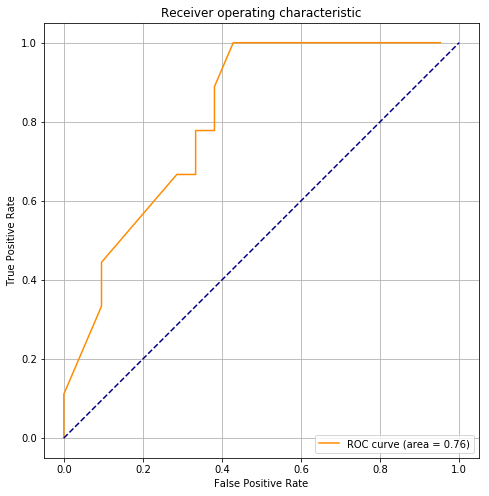

In [21]:
roc_auc = auc(fpr_values, tpr_values)
plt.figure(figsize=(8,8))
plt.plot(fpr_values, tpr_values, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()